# Data Center 2Ø cooling

# Refrigerant at various quality in evaporator



## Speed of sound

### 1. Homogeneous Equilibrium Model (HEM)

### Assumptions
- Two-phase mixture behaves as a single pseudo-fluid.
- Thermal and mechanical equilibrium between phases.
- No slip between liquid and vapor (same velocity).

### Derivation
Start from:
$$
c^2 = \left( \frac{\partial p}{\partial \rho} \right)_s
$$

For HEM:
$$
\frac{1}{\rho} = \frac{x}{\rho_v} + \frac{1-x}{\rho_l}
$$

Differentiate under isentropic conditions:
$$
\frac{\partial p}{\partial \rho} = \frac{1}{\left( \frac{\partial \rho}{\partial p} \right)_s}
$$

Using mixture compressibility:
$$
\beta_m = \frac{x}{\rho_v c_v^2} + \frac{1-x}{\rho_l c_l^2}
$$

So:
$$
c_{\text{HEM}} = \sqrt{\frac{1}{\rho_m \beta_m}}
$$

---

### 2. Wood’s Equation (Classic Two-Phase Approximation)

### Assumptions
- Phases individually compressible.
- No thermal relaxation (instantaneous equilibrium).
- Volume fractions determine effective compressibility.

### Formula
$$
\frac{1}{\rho_m c_m^2} = \frac{\alpha_v}{\rho_v c_v^2} + \frac{\alpha_l}{\rho_l c_l^2}
$$
Where:
- $\alpha_v, \alpha_l$ = volume fractions
- $\rho_v, \rho_l$ = densities
- $c_v, c_l$ = speed of sound in vapor and liquid

---

### 3. Relaxation Model (Frequency-Dependent)

### Why needed
- At finite frequencies, thermal and mass transfer between phases may not keep up with acoustic oscillations.
- Leads to dispersion (speed depends on frequency) and attenuation.

### Single-Debye Relaxation
Bulk modulus:
$$
K(\omega) = K_\infty + \frac{K_0 - K_\infty}{1 + i\omega\tau}
$$

Where:
- $K_0$ = relaxed modulus (full equilibrium)
- $K_\infty$ = frozen modulus (no phase change)
- $\tau$ = relaxation time
- $\omega = 2\pi f$

Speed of sound:
$$
c(\omega) = \sqrt{\frac{\Re\{K(\omega)\}}{\rho}}
$$
Attenuation:
$$
\alpha(\omega) \propto \frac{\omega \Im\{K(\omega)\}}{\Re\{K(\omega)\}}
$$

### Interpretation
- $\omega\tau \ll 1$: relaxed → low speed
- $\omega\tau \gg 1$: frozen → high speed

| **Item** | **Purpose (Why chosen)** | **Key formulas** | **Suggestions / Notes** |
|:--------:|:-------------------------:|:-----------------:|:------------------------:|
| **Frequency sweep** (20 Hz, 200 Hz, 2 kHz) | Spans relaxed → dispersive → frozen regimes for speed of sound and attenuation. | $\omega = 2\pi f$; $\omega\tau = (2\pi f)\tau$. Relaxed if $\omega\tau \ll 1$; frozen if $\omega\tau \gg 1$; dispersive if $\omega\tau \approx 1\text{–}10$. | Add intermediate points (e.g., 50 Hz, 500 Hz) for better resolution. |
| **$\tau$ sensitivity** (0.5 ms, 2 ms, 20 ms) | Captures bubble-size and interfacial transfer effects. | $t_{\text{th}} \approx R^2/\alpha$ (thermal diffusion time). | Extend range to 0.1 ms and 100 ms; relate $\tau$ to bubble size distribution if possible. |
| **Check EOS consistency** (REFPROP/CoolProp) | Ensures accurate thermodynamic properties for $c$ calculation. | $c = \sqrt{K/\rho}$; use $K_0$ (relaxed) and $K_\infty$ (frozen) for bounds. | Validate EOS outputs near saturation; reduce $dT$ step or use complex-step differentiation if needed. |
| **Plot dispersion curve** ($c$ vs $f$) | Visualizes transition and attenuation peak near $\omega\tau \approx 1$. | $K(\omega) = K_\infty + \dfrac{K_0 - K_\infty}{1 + i\omega\tau}$; $c(\omega) = \sqrt{\dfrac{\Re\{K(\omega)\}}{\rho}}$; $\alpha(\omega) \propto \dfrac{\omega \Im\{K(\omega)\}}{\Re\{K(\omega)\}}$. | Plot both $c(\omega)$ and $\alpha(\omega)$; consider two-Debye model if multiple mechanisms exist. |

=== Comparison at T_sat = 318.15 K (45.00 °C) ===
Model params: freq = 200.0 Hz, tau = 5.000e-03 s, dT_saturation = 0.050 K
     Q     HEM [m/s]  Frozen [m/s]   Relax |a| [m/s]
  0.10       29.4291       58.1821           57.8434
  0.30       60.4462       80.0884           79.7521
  0.50       85.2016       98.0491           97.7878
  0.70      106.1426      113.3026          113.1415
  0.90      124.4982      126.7655          126.7109

SVG plot saved to: speed_of_sound_HEM_Frozen_Relaxed_TP.svg


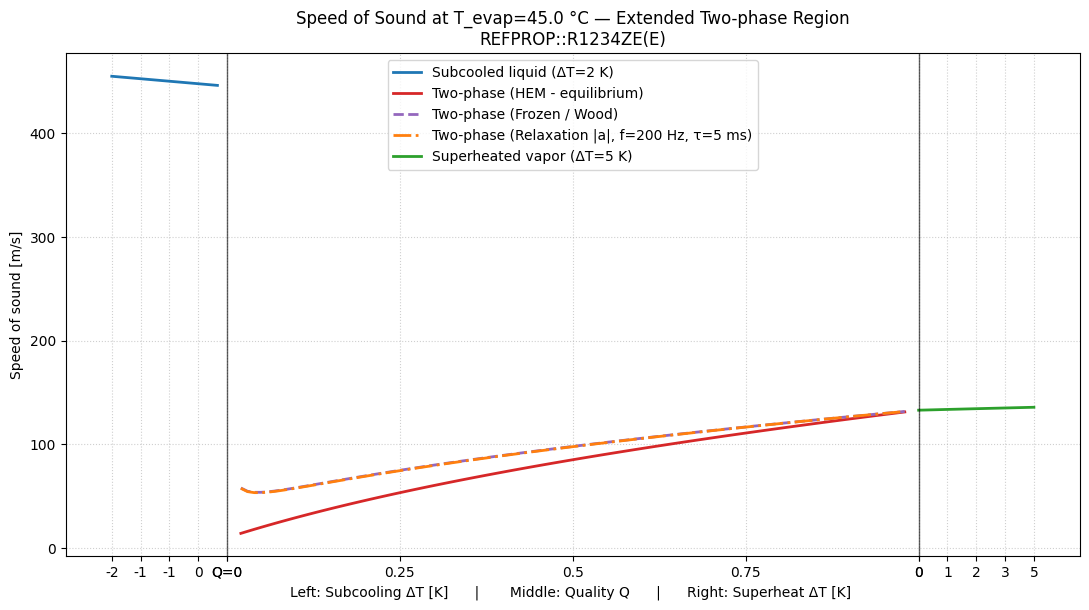

In [1]:
# -*- coding: utf-8 -*-
"""
Speed of sound: Subcool -> Two-phase -> Superheat
Two-phase region visually extended; single-phase regions visually compressed.

Models: Improved HEM (equilibrium), Frozen (Wood), Relaxation (frequency-dependent)
Saves SVG plot.
"""

import math
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

# ==========================
# Config (edit as needed)
# ==========================
fluid = "REFPROP::R1234ZE(E)"   # or "HEOS::R1234ZE(E)"
T_evap_C = 45.0                 # evaporating saturation temperature [°C]

# Thermal extents (actual thermodynamic ranges)
subcool_K = 2.0                 # was 5 K -> reduced to 2 K
superheat_K = 5.0               # was 10 K -> reduced to 5 K
# Visual widths (axis space allocation for each segment)
L_sub = 0.5                     # width of subcooled segment on x-axis (compressed)
L_tp  = 3.0                     # width of two-phase segment on x-axis (extended)
L_sup = 0.5                     # width of superheated segment on x-axis (compressed)

# Model params
dT_sat = 0.05                   # central-diff step along saturation [K] for improved HEM
freq_hz = 200.0                 # frequency for relaxation model [Hz]
tau_s = 0.005                   # relaxation time [s] (e.g., 5 ms)
svg_file = "speed_of_sound_HEM_Frozen_Relaxed_TP.svg"

# ==========================
# Helpers
# ==========================
def _sat_props_T(fluid, T):
    p = CP.PropsSI("P", "T", T, "Q", 0.5, fluid)
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)
    v_l = 1.0 / rho_l
    v_v = 1.0 / rho_v
    s_l = CP.PropsSI("S", "T", T, "Q", 0.0, fluid)
    s_v = CP.PropsSI("S", "T", T, "Q", 1.0, fluid)
    return {"p": p, "v_l": v_l, "v_v": v_v, "s_l": s_l, "s_v": s_v}

def _central_diff(f_plus, f_minus, dT):
    return (f_plus - f_minus) / (2.0 * dT)

# ==========================
# Improved HEM (equilibrium)
# ==========================
def hem_speed_of_sound_eq_TQ(fluid, T, Q, dT=0.05):
    if not (0.0 < Q < 1.0):
        raise ValueError("Quality Q must be strictly between 0 and 1 for two-phase HEM.")
    if dT <= 0.0:
        raise ValueError("dT must be positive.")

    base = _sat_props_T(fluid, T)
    p0, v_l0, v_v0, s_l0, s_v0 = base["p"], base["v_l"], base["v_v"], base["s_l"], base["s_v"]

    ds = (s_v0 - s_l0)
    if abs(ds) < 1e-6:
        raise RuntimeError("Entropy difference between phases is too small (near critical).")

    plus = _sat_props_T(fluid, T + dT)
    minus = _sat_props_T(fluid, T - dT)

    dpdT  = _central_diff(plus["p"],   minus["p"],   dT)
    dvldT = _central_diff(plus["v_l"], minus["v_l"], dT)
    dvvdT = _central_diff(plus["v_v"], minus["v_v"], dT)
    dsldT = _central_diff(plus["s_l"], minus["s_l"], dT)
    dsvdT = _central_diff(plus["s_v"], minus["s_v"], dT)

    numerator = (1.0 - Q) * dsldT + Q * dsvdT
    dQdT = - numerator / ds

    v_mix = (1.0 - Q) * v_l0 + Q * v_v0
    dvdT  = (1.0 - Q) * dvldT + Q * dvvdT + (v_v0 - v_l0) * dQdT

    drhodT = - dvdT / (v_mix**2)
    if abs(dpdT) < 1e-12 or not math.isfinite(dpdT):
        raise RuntimeError("dp/dT along saturation is too small or invalid (near critical?).")
    drhodp_s = drhodT / dpdT

    if drhodp_s <= 0 or not math.isfinite(drhodp_s):
        raise RuntimeError(f"Non-physical or ill-conditioned dρ/dp|_s = {drhodp_s:.3e}.")
    a2 = 1.0 / drhodp_s
    if a2 <= 0 or not math.isfinite(a2):
        raise RuntimeError("Computed a^2 is invalid.")
    return math.sqrt(a2)

# ==========================
# Frozen (Wood)
# ==========================
def frozen_speed_of_sound_TQ(fluid, T, Q, dp=100.0):
    if not (0.0 < Q < 1.0):
        raise ValueError("Quality Q must be in (0,1).")
    p_sat = CP.PropsSI("P", "T", T, "Q", 0.5, fluid)
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)

    alpha_v = (Q / rho_v) / (Q / rho_v + (1.0 - Q) / rho_l)
    alpha_l = 1.0 - alpha_v

    a_l = CP.PropsSI("A", "T", T, "P", p_sat + abs(dp), fluid)  # liquid side
    a_v = CP.PropsSI("A", "T", T, "P", p_sat - abs(dp), fluid)  # vapor side

    v_mix = (1.0 - Q) / rho_l + Q / rho_v
    rho_mix = 1.0 / v_mix

    inv_rho_a2 = alpha_l / (rho_l * a_l**2) + alpha_v / (rho_v * a_v**2)
    a2 = 1.0 / (rho_mix * inv_rho_a2)
    return math.sqrt(a2)

# ==========================
# Relaxation (frequency-dependent)
# ==========================
def relaxed_speed_of_sound_TQ(fluid, T, Q, freq_hz, tau_s, dT=0.05, dp_for_frozen=100.0):
    if not (0.0 < Q < 1.0):
        raise ValueError("Quality Q must be in (0,1).")

    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)
    v_mix = (1.0 - Q) / rho_l + Q / rho_v
    rho_mix = 1.0 / v_mix

    a_eq = hem_speed_of_sound_eq_TQ(fluid, T, Q, dT=dT)
    a_fr = frozen_speed_of_sound_TQ(fluid, T, Q, dp=dp_for_frozen)

    K_eq = rho_mix * a_eq**2
    K_fr = rho_mix * a_fr**2

    omega = 2.0 * math.pi * freq_hz
    jwt = 1j * omega * tau_s
    K_omega = K_eq + (K_fr - K_eq) * (jwt / (1.0 + jwt))
    a2_omega = K_omega / rho_mix
    return a2_omega**0.5  # complex

# ==========================
# 1) PRINT COMPARISON
# ==========================
T_sat = T_evap_C + 273.15
print("=== Comparison at T_sat = {:.2f} K ({:.2f} °C) ===".format(T_sat, T_evap_C))
print("Model params: freq = {:.1f} Hz, tau = {:.3e} s, dT_saturation = {:.3f} K".format(freq_hz, tau_s, dT_sat))
print("{:>6s}  {:>12s}  {:>12s}  {:>16s}".format("Q", "HEM [m/s]", "Frozen [m/s]", "Relax |a| [m/s]"))

for Q in [0.1, 0.3, 0.5, 0.7, 0.9]:
    a_eq = hem_speed_of_sound_eq_TQ(fluid, T_sat, Q, dT=dT_sat)
    a_fr = frozen_speed_of_sound_TQ(fluid, T_sat, Q, dp=100.0)
    a_rel_c = relaxed_speed_of_sound_TQ(fluid, T_sat, Q, freq_hz=freq_hz, tau_s=tau_s, dT=dT_sat)
    print("{:6.2f}  {:12.4f}  {:12.4f}  {:16.4f}".format(Q, a_eq, a_fr, abs(a_rel_c)))

# ==========================
# 2) PLOT with extended two-phase visual width
# ==========================
# Compute evaporating pressure and safe nudge
p_evap = CP.PropsSI("P", "T", T_sat, "Q", 0.5, fluid)
dp_side = max(50.0, 1e-6 * p_evap)

# ---- Build composite x-axis with controllable segment widths ----
# We'll map each physical segment to a visual segment of width L_sub, L_tp, L_sup.

# Subcooled segment (physical: ΔT ∈ [-subcool_K, 0], visual x ∈ [0, L_sub])
N_sub = max(6, int(6 * max(subcool_K, 1))) if subcool_K > 0 else 0
if N_sub > 0:
    t_sub = np.linspace(-subcool_K, 0.0, N_sub, endpoint=False)  # avoid 0 to not overlap with TP
    x_sub = np.linspace(0.0, L_sub, N_sub, endpoint=False)
    T_sub = T_sat + t_sub
else:
    x_sub = np.array([])
    T_sub = np.array([])

# Two-phase segment (physical: Q ∈ [0,1], visual x ∈ [L_sub, L_sub + L_tp])
N_tp = 100  # dense sampling for two-phase
Q_vals = np.linspace(0.02, 0.98, N_tp)  # avoid edges
x_tp = L_sub + (Q_vals - 0.0) * (L_tp / 1.0)

# Superheated segment (physical: ΔT ∈ (0, superheat_K], visual x ∈ (L_sub + L_tp, L_sub + L_tp + L_sup])
N_sup = max(6, int(6 * max(superheat_K, 1))) if superheat_K > 0 else 0
if N_sup > 0:
    t_sup = np.linspace(0.0, superheat_K, N_sup, endpoint=True)
    # Avoid duplicating the boundary point visually
    x_sup = L_sub + L_tp + np.linspace(0.0, L_sup, N_sup)
    T_sup = T_sat + t_sup
else:
    x_sup = np.array([])
    T_sup = np.array([])

# ---- Compute speeds ----
# Single-phase (subcooled liquid): call 'A' just off saturation pressure
if x_sub.size:
    a_sub = np.array([CP.PropsSI("A", "T", Ti, "P", p_evap + dp_side, fluid) for Ti in T_sub])
else:
    a_sub = np.array([])

# Two-phase models
a_tp_hem = []
a_tp_frozen = []
a_tp_relax_mag = []
for Qi in Q_vals:
    a_tp_hem.append(hem_speed_of_sound_eq_TQ(fluid, T_sat, Qi, dT=dT_sat))
    a_tp_frozen.append(frozen_speed_of_sound_TQ(fluid, T_sat, Qi, dp=100.0))
    a_tp_relax_mag.append(abs(relaxed_speed_of_sound_TQ(fluid, T_sat, Qi, freq_hz=freq_hz, tau_s=tau_s, dT=dT_sat)))
a_tp_hem = np.array(a_tp_hem)
a_tp_frozen = np.array(a_tp_frozen)
a_tp_relax_mag = np.array(a_tp_relax_mag)

# Single-phase (superheated vapor)
if x_sup.size:
    a_sup = np.array([CP.PropsSI("A", "T", Ti, "P", p_evap - dp_side, fluid) for Ti in T_sup])
else:
    a_sup = np.array([])

# ---- Plot ----
plt.figure(figsize=(11, 6.2))

if x_sub.size:
    plt.plot(x_sub, a_sub, label=f"Subcooled liquid (ΔT={subcool_K:.0f} K)", color="#1f77b4", lw=2)
plt.plot(x_tp, a_tp_hem, label="Two-phase (HEM - equilibrium)", color="#d62728", lw=2)
plt.plot(x_tp, a_tp_frozen, label="Two-phase (Frozen / Wood)", color="#9467bd", lw=2, ls="--")
plt.plot(x_tp, a_tp_relax_mag, label=f"Two-phase (Relaxation |a|, f={freq_hz:.0f} Hz, τ={tau_s*1e3:.0f} ms)", color="#ff7f0e", lw=2, ls="-.")

if x_sup.size:
    plt.plot(x_sup, a_sup, label=f"Superheated vapor (ΔT={superheat_K:.0f} K)", color="#2ca02c", lw=2)

# Boundaries
plt.axvline(L_sub, color="k", lw=1, alpha=0.6)
plt.axvline(L_sub + L_tp, color="k", lw=1, alpha=0.6)

# Labels
plt.title(f"Speed of Sound at T_evap={T_evap_C:.1f} °C — Extended Two-phase Region\n{fluid}")
plt.ylabel("Speed of sound [m/s]")

# Build custom x-ticks:
ticks = []
labels = []

# Subcool ticks: relative to T_sat (negative means subcooling)
if x_sub.size:
    ticks += list(np.linspace(0.0, L_sub, min(5, N_sub)))
    # map ticks to approximate ΔT labels
    tvals = np.linspace(-subcool_K, 0.0, min(5, N_sub), endpoint=False)
    labels += [f"{int(tv):d}" for tv in tvals]

# Two-phase ticks: show Q
tp_ticks = np.linspace(L_sub, L_sub + L_tp, 5)
ticks += list(tp_ticks)
labels += ["Q=0", "0.25", "0.5", "0.75", "1.0"]

# Superheat ticks: ΔT labels
if x_sup.size:
    ticks += list(np.linspace(L_sub + L_tp, L_sub + L_tp + L_sup, min(5, N_sup)))
    tvals = np.linspace(0.0, superheat_K, min(5, N_sup))
    labels += [f"{int(tv):d}" for tv in tvals]

plt.xticks(ticks, labels)
plt.xlabel(
    "Left: Subcooling ΔT [K]      |       Middle: Quality Q      |      Right: Superheat ΔT [K] "
)

plt.grid(True, ls=":", alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(svg_file, format="svg")
print(f"\nSVG plot saved to: {svg_file}")
plt.show()


### Using effective speed of sound
This is what I got from Ahmed, seem to be a simplified HEM, the derivative term is simplified with small DP


In [ ]:
def compute_effective_speed_of_sound_PQ(fluid, pressure, quality):
    """
    Compute the effective speed of sound for a two-phase mixture under HEM assumptions,
    using pressure and quality as inputs.

    Parameters:
        pressure (float): Local pressure [Pa].
        quality (float): Vapor quality (mass fraction of vapor, 0 ≤ x ≤ 1) [-].

    Returns:
        float: Effective speed of sound [m/s].
    """
    delta_p = 0.0000001  # Small pressure perturbation in Pa
    # Ensure valid inputs for pressure and quality
    if pressure <= 0:
        raise ValueError("Pressure must be greater than 0.")

    # Replace with your working fluid
    fluid_name = fluid

    # Liquid and vapor densities
    liquid_density = CP.PropsSI("D", "P", pressure, "Q", 0, fluid_name)
    vapor_density = CP.PropsSI("D", "P", pressure, "Q", 1, fluid_name)

    # Void fractions (volumetric) for liquid and vapor phases
    alpha_v = quality / (quality + (1 - quality) * (vapor_density / liquid_density))
    alpha_l = 1 - alpha_v  # Liquid void fraction

    # Speeds of sound for liquid (c_L) and vapor (c_V)
    c_l = CP.PropsSI("A", "P", pressure, "Q", 0, fluid_name)
    c_v = CP.PropsSI("A", "P", pressure, "Q", 1, fluid_name)

    # Heat capacities at constant pressure c_p for liquid and vapor
    cp_l = CP.PropsSI("C", "P", pressure, "Q", 0, fluid_name)
    cp_v = CP.PropsSI("C", "P", pressure, "Q", 1, fluid_name)

    # Temperature of the system
    temperature = CP.PropsSI("T", "P", pressure, "Q", quality, fluid_name)

    # Calculate (dS/dP)_sat for liquid and vapor using finite difference

    s_l_plus = CP.PropsSI("S", "P", pressure + delta_p, "Q", 0, fluid_name)
    s_l_minus = CP.PropsSI("S", "P", pressure - delta_p, "Q", 0, fluid_name)
    ds_dp_l = (s_l_plus - s_l_minus) / (2 * delta_p)

    s_v_plus = CP.PropsSI("S", "P", pressure + delta_p, "Q", 1, fluid_name)
    s_v_minus = CP.PropsSI("S", "P", pressure - delta_p, "Q", 1, fluid_name)
    ds_dp_v = (s_v_plus - s_v_minus) / (2 * delta_p)

    # HEM speed-of-sound equation
    inv_rho_c2 = (
            alpha_l / (liquid_density * (c_l ** 2))
            + alpha_v / (vapor_density * (c_v ** 2))
            + temperature
            * (
                    (alpha_l * liquid_density / cp_l) * (ds_dp_l ** 2)
                    + (alpha_v * vapor_density / cp_v) * (ds_dp_v ** 2)
            )
    )

    # Effective speed of sound (m/s)
    effective_speed_of_sound = (1 / (
                inv_rho_c2 * (1 / ((1 - quality) / liquid_density + quality / vapor_density)))) ** 0.5

    return effective_speed_of_sound


print(compute_effective_speed_of_sound_PQ('R1234ZEE',1e6,0.5))

### Comparing all above

Fluid: REFPROP::R1234ZE(E)
Evaporator: Tsat = 45.00 °C, psat = 8.761 bar(a)
Models at f=200 Hz, τ=5 ms, dT_sat=0.05 K

  x     HEM(eq) [m/s]   Frozen [m/s]   Relax |a| [m/s]   P–Q (stable) [m/s]
  0.2         45.9613        69.6151          69.2642            45.9616
  0.5         85.2016        98.0477          97.7864            85.2026
  0.8        115.5913       120.2183         120.1102           115.5928

SVG saved to: speed_of_sound_comparison_subcool_TP_superheat.svg


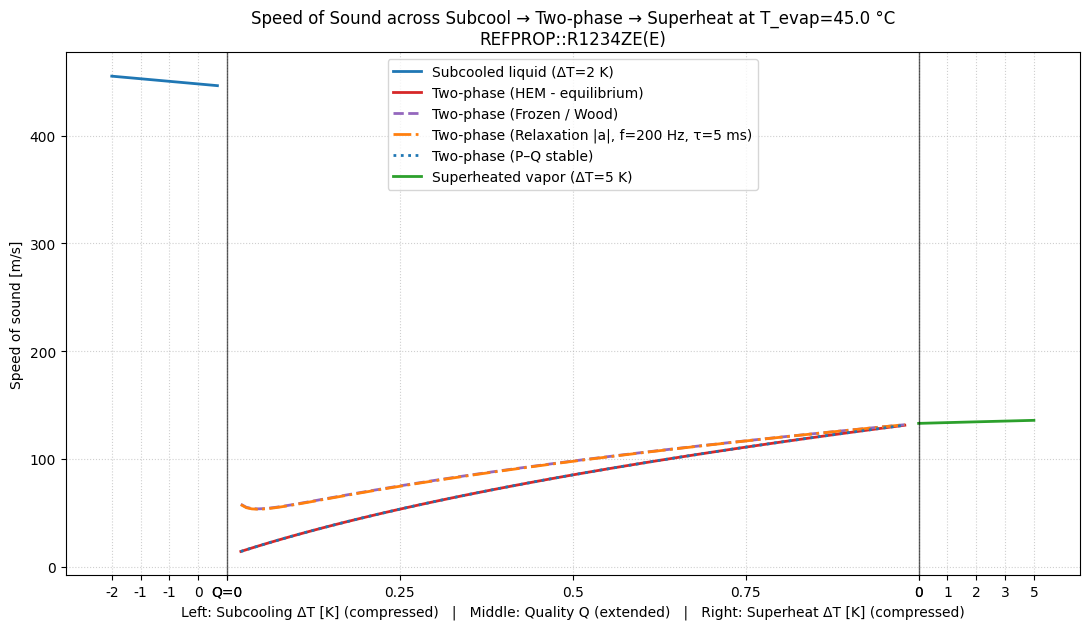

In [3]:
# -*- coding: utf-8 -*-
"""
Speed of sound comparison across Subcool -> Two-phase -> Superheat (same evaporator pressure)
Models compared in two-phase:
  1) HEM (equilibrium, improved along saturation)
  2) Frozen (Wood)
  3) Relaxation (frequency-dependent blend of HEM & Frozen)
  4) P–Q method (stabilized with ds/dp along saturation)

Also plots single-phase speed of sound for subcooled liquid and superheated vapor.
Saves SVG.

Requires: numpy, matplotlib, CoolProp
"""

import math
import numpy as np
import matplotlib.pyplot as plt
import CoolProp.CoolProp as CP

# ==========================
# CONFIG (edit as needed)
# ==========================
USE_REFPROP = True
fluid = "REFPROP::R1234ZE(E)" if USE_REFPROP else "HEOS::R1234ZE(E)"

# Evaporating saturation temperature and derived pressure
T_evap_C = 45.0                     # Tsat [°C]
T_sat = T_evap_C + 273.15           # [K]
p_evap = CP.PropsSI("P", "T", T_sat, "Q", 0.5, fluid)

# Single-phase thermal extents
subcool_K = 2.0                     # subcooling range [K] (left)
superheat_K = 5.0                   # superheat range [K] (right)

# Visual widths (x-axis allocation for each segment)
L_sub = 0.5                         # subcooled region width
L_tp  = 3.0                         # two-phase region width
L_sup = 0.5                         # superheated region width

# Two-phase model settings
dT_sat = 0.05                       # central-diff step along saturation [K] for HEM/PQ
dp_side = max(50.0, 1e-6 * p_evap)  # Pa, tiny nudge off saturation for single-phase 'A'

# Relaxation (dispersion) params
freq_hz = 200.0
tau_s = 0.005                       # s (5 ms)

# Qualities for printed comparison
qualities_compare = [0.2, 0.5, 0.8]

# Plot export
save_svg = True
svg_filename = "Plot/speed_of_sound_comparison_subcool_TP_superheat.svg"

# ==========================
# Helpers: saturated properties and diffs
# ==========================
def sat_props_T(fluid, T):
    """Saturated properties at temperature T [K]."""
    p = CP.PropsSI("P", "T", T, "Q", 0.5, fluid)
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)
    v_l = 1.0 / rho_l
    v_v = 1.0 / rho_v
    s_l = CP.PropsSI("S", "T", T, "Q", 0.0, fluid)
    s_v = CP.PropsSI("S", "T", T, "Q", 1.0, fluid)
    return {"p": p, "rho_l": rho_l, "rho_v": rho_v, "v_l": v_l, "v_v": v_v, "s_l": s_l, "s_v": s_v}

def central_diff(f_plus, f_minus, d):
    """Central difference derivative."""
    return (f_plus - f_minus) / (2.0 * d)

# ==========================
# Two-phase models
# ==========================
def hem_speed_of_sound_eq_TQ(fluid, T, Q, dT=0.05):
    """
    Improved HEM (equilibrium) speed of sound at saturated (T, Q).
    Derivatives taken along saturation:
      a^2 = (∂p/∂ρ)_s , enforcing isentropic constraint.
    """
    if not (0.0 < Q < 1.0):
        raise ValueError("Quality Q must be in (0,1) for two-phase HEM.")

    base = sat_props_T(fluid, T)
    p0, v_l0, v_v0, s_l0, s_v0 = base["p"], base["v_l"], base["v_v"], base["s_l"], base["s_v"]
    ds = s_v0 - s_l0
    if abs(ds) < 1e-6:
        raise RuntimeError("Near critical: s_v - s_l too small.")

    plus  = sat_props_T(fluid, T + dT)
    minus = sat_props_T(fluid, T - dT)

    dpdT  = central_diff(plus["p"],   minus["p"],   dT)
    dvldT = central_diff(plus["v_l"], minus["v_l"], dT)
    dvvdT = central_diff(plus["v_v"], minus["v_v"], dT)
    dsldT = central_diff(plus["s_l"], minus["s_l"], dT)
    dsvdT = central_diff(plus["s_v"], minus["s_v"], dT)

    # isentropic constraint -> dQ/dT
    dQdT = - ((1.0 - Q)*dsldT + Q*dsvdT) / ds

    v_mix = (1.0 - Q) * v_l0 + Q * v_v0
    dvdT  = (1.0 - Q) * dvldT + Q * dvvdT + (v_v0 - v_l0) * dQdT

    drhodT = - dvdT / (v_mix**2)
    if abs(dpdT) < 1e-12:
        raise RuntimeError("dp/dT along saturation too small.")
    drhodp_s = drhodT / dpdT

    if drhodp_s <= 0 or not math.isfinite(drhodp_s):
        raise RuntimeError("Invalid dρ/dp|s in HEM.")
    a2 = 1.0 / drhodp_s
    if a2 <= 0 or not math.isfinite(a2):
        raise RuntimeError("Invalid a^2 (HEM).")
    return math.sqrt(a2)

def frozen_speed_of_sound_TQ(fluid, T, Q, dp=100.0):
    """
    Frozen (Wood) model: no phase change participates.
    Uses single-phase sounds just off saturation at ±dp.
    """
    if not (0.0 < Q < 1.0):
        raise ValueError("Quality Q must be in (0,1).")
    p_sat = CP.PropsSI("P", "T", T, "Q", 0.5, fluid)
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)

    # single-phase sounds at slightly off-sat pressures
    a_l = CP.PropsSI("A", "T", T, "P", p_sat + abs(dp), fluid)
    a_v = CP.PropsSI("A", "T", T, "P", p_sat - abs(dp), fluid)

    # no-slip void fraction and mixture density
    alpha_v = (Q / rho_v) / (Q / rho_v + (1.0 - Q) / rho_l)
    alpha_l = 1.0 - alpha_v
    rho_mix = 1.0 / ((1.0 - Q)/rho_l + Q/rho_v)

    inv_rho_a2 = alpha_l / (rho_l * a_l**2) + alpha_v / (rho_v * a_v**2)
    a2 = 1.0 / (rho_mix * inv_rho_a2)
    return math.sqrt(a2)

def relaxed_speed_of_sound_TQ(fluid, T, Q, freq_hz, tau_s, dT=0.05, dp_for_frozen=100.0):
    """
    Single-relaxation dispersion model: blends HEM (low-f) and Frozen (high-f).
    Returns complex a(ω); magnitude is plotted.
    """
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)
    rho_mix = 1.0 / ((1.0 - Q)/rho_l + Q/rho_v)

    a_eq = hem_speed_of_sound_eq_TQ(fluid, T, Q, dT=dT)
    a_fr = frozen_speed_of_sound_TQ(fluid, T, Q, dp=dp_for_frozen)

    K_eq = rho_mix * a_eq**2
    K_fr = rho_mix * a_fr**2

    omega = 2.0 * math.pi * freq_hz
    jwt = 1j * omega * tau_s
    K_omega = K_eq + (K_fr - K_eq) * (jwt / (1.0 + jwt))
    a2_omega = K_omega / rho_mix
    return a2_omega**0.5  # complex

def compute_effective_speed_of_sound_PQ_stable(fluid, pressure, quality, dT=0.05):
    """
    Stabilized variant of your P–Q method:
      - Map P -> Tsat to stay on saturation.
      - Evaluate ds/dp|sat via (ds/dT)/(dp/dT) using central diffs in T.
      - Use single-phase 'A' by nudging pressure ±dp.
    """
    if not (0.0 < quality < 1.0):
        raise ValueError("quality must be in (0,1).")
    if pressure <= 0:
        raise ValueError("pressure must be > 0.")

    T_sat_loc = CP.PropsSI("T", "P", pressure, "Q", 0.5, fluid)
    base = sat_props_T(fluid, T_sat_loc)
    rho_l = base["rho_l"]; rho_v = base["rho_v"]

    rho_mix = 1.0 / ((1.0 - quality)/rho_l + quality/rho_v)
    alpha_v = (quality / rho_v) / (quality / rho_v + (1.0 - quality) / rho_l)
    alpha_l = 1.0 - alpha_v

    # single-phase sounds near saturation at same T
    c_l = CP.PropsSI("A", "T", T_sat_loc, "P", pressure + max(50.0, 1e-6*pressure), fluid)
    c_v = CP.PropsSI("A", "T", T_sat_loc, "P", pressure - max(50.0, 1e-6*pressure), fluid)

    cp_l = CP.PropsSI("C", "T", T_sat_loc, "Q", 0.0, fluid)
    cp_v = CP.PropsSI("C", "T", T_sat_loc, "Q", 1.0, fluid)

    plus  = sat_props_T(fluid, T_sat_loc + dT)
    minus = sat_props_T(fluid, T_sat_loc - dT)
    dsldT = central_diff(plus["s_l"], minus["s_l"], dT)
    dsvdT = central_diff(plus["s_v"], minus["s_v"], dT)
    dpdT  = central_diff(plus["p"],   minus["p"],   dT)
    if abs(dpdT) < 1e-12:
        raise RuntimeError("dp/dT too small for ds/dp evaluation.")

    ds_dp_l = dsldT / dpdT
    ds_dp_v = dsvdT / dpdT

    inv_rho_a2 = (
        alpha_l / (rho_l * c_l**2) +
        alpha_v / (rho_v * c_v**2) +
        T_sat_loc * ((alpha_l * rho_l / cp_l) * ds_dp_l**2 +
                     (alpha_v * rho_v / cp_v) * ds_dp_v**2)
    )
    a2 = 1.0 / (rho_mix * inv_rho_a2)
    if a2 <= 0 or not math.isfinite(a2):
        raise RuntimeError("Invalid a^2 in P–Q method.")
    return math.sqrt(a2)

# ==========================
# 1) PRINT COMPARISON at x = 0.2, 0.5, 0.8
# ==========================
print(f"Fluid: {fluid}")
print(f"Evaporator: Tsat = {T_evap_C:.2f} °C, psat = {p_evap/1e5:.3f} bar(a)")
print(f"Models at f={freq_hz:.0f} Hz, τ={tau_s*1e3:.0f} ms, dT_sat={dT_sat:.2f} K")
print("\n  x     HEM(eq) [m/s]   Frozen [m/s]   Relax |a| [m/s]   P–Q (stable) [m/s]")

for x in qualities_compare:
    a_eq  = hem_speed_of_sound_eq_TQ(fluid, T_sat, x, dT=dT_sat)
    a_fr  = frozen_speed_of_sound_TQ(fluid, T_sat, x, dp=dp_side)
    a_rel = relaxed_speed_of_sound_TQ(fluid, T_sat, x, freq_hz, tau_s, dT=dT_sat, dp_for_frozen=dp_side)
    a_pq  = compute_effective_speed_of_sound_PQ_stable(fluid, p_evap, x, dT=dT_sat)
    print(f" {x:4.1f}    {a_eq:12.4f}   {a_fr:12.4f}     {abs(a_rel):12.4f}     {a_pq:14.4f}")

# ==========================
# 2) PLOT: Subcool -> Two-phase -> Superheat
# ==========================
# Build composite x-axis with controllable segment widths
# Subcooled: ΔT in [-subcool_K, 0), visual x in [0, L_sub)
N_sub = max(6, int(6 * max(subcool_K, 1))) if subcool_K > 0 else 0
if N_sub > 0:
    t_sub = np.linspace(-subcool_K, 0.0, N_sub, endpoint=False)   # avoid exactly 0
    x_sub = np.linspace(0.0, L_sub, N_sub, endpoint=False)
    T_sub = T_sat + t_sub
else:
    x_sub = np.array([]); T_sub = np.array([])

# Two-phase: Q in [0.02, 0.98], visual x in [L_sub, L_sub+L_tp]
Q_vals = np.linspace(0.02, 0.98, 121)
x_tp = L_sub + (Q_vals - 0.0) * (L_tp / 1.0)

# Superheated: ΔT in (0, superheat_K], visual x in (L_sub+L_tp, L_sub+L_tp+L_sup]
N_sup = max(6, int(6 * max(superheat_K, 1))) if superheat_K > 0 else 0
if N_sup > 0:
    t_sup = np.linspace(0.0, superheat_K, N_sup, endpoint=True)
    x_sup = L_sub + L_tp + np.linspace(0.0, L_sup, N_sup)
    T_sup = T_sat + t_sup
else:
    x_sup = np.array([]); T_sup = np.array([])

# Single-phase speeds
a_sub = np.array([
    CP.PropsSI("A", "T", Ti, "P", p_evap + dp_side, fluid) for Ti in T_sub
]) if x_sub.size else np.array([])

a_sup = np.array([
    CP.PropsSI("A", "T", Ti, "P", p_evap - dp_side, fluid) for Ti in T_sup
]) if x_sup.size else np.array([])

# Two-phase model curves across Q
a_tp_hem = np.array([hem_speed_of_sound_eq_TQ(fluid, T_sat, q, dT=dT_sat) for q in Q_vals])
a_tp_fr  = np.array([frozen_speed_of_sound_TQ(fluid, T_sat, q, dp=dp_side) for q in Q_vals])
a_tp_rel = np.array([abs(relaxed_speed_of_sound_TQ(fluid, T_sat, q, freq_hz, tau_s, dT=dT_sat, dp_for_frozen=dp_side)) for q in Q_vals])
a_tp_pq  = np.array([compute_effective_speed_of_sound_PQ_stable(fluid, p_evap, q, dT=dT_sat) for q in Q_vals])

# Plot
plt.figure(figsize=(11.0, 6.4))

# Subcooled and superheated single-phase
if x_sub.size:
    plt.plot(x_sub, a_sub, label=f"Subcooled liquid (ΔT={subcool_K:.0f} K)", color="#1f77b4", lw=2)
plt.plot(x_tp, a_tp_hem, label="Two-phase (HEM - equilibrium)", color="#d62728", lw=2)
plt.plot(x_tp, a_tp_fr,  label="Two-phase (Frozen / Wood)", color="#9467bd", lw=2, ls="--")
plt.plot(x_tp, a_tp_rel, label=f"Two-phase (Relaxation |a|, f={freq_hz:.0f} Hz, τ={tau_s*1e3:.0f} ms)", color="#ff7f0e", lw=2, ls="-.")
plt.plot(x_tp, a_tp_pq,  label="Two-phase (P–Q stable)", color="#1f77b4", lw=2, ls=":")

if x_sup.size:
    plt.plot(x_sup, a_sup, label=f"Superheated vapor (ΔT={superheat_K:.0f} K)", color="#2ca02c", lw=2)

# Region boundaries
plt.axvline(L_sub, color="k", lw=1, alpha=0.6)
plt.axvline(L_sub + L_tp, color="k", lw=1, alpha=0.6)

# Labels and ticks
plt.title(f"Speed of Sound across Subcool → Two-phase → Superheat at T_evap={T_evap_C:.1f} °C\n{fluid}")
plt.ylabel("Speed of sound [m/s]")

ticks = []
labels = []

# Subcool ticks: show ΔT (negative)
if x_sub.size:
    ticks += list(np.linspace(0.0, L_sub, min(5, N_sub)))
    tvals = np.linspace(-subcool_K, 0.0, min(5, N_sub), endpoint=False)
    labels += [f"{int(tv):d}" for tv in tvals]

# Two-phase ticks: show Q
tp_ticks = np.linspace(L_sub, L_sub + L_tp, 5)
ticks += list(tp_ticks)
labels += ["Q=0", "0.25", "0.5", "0.75", "1.0"]

# Superheat ticks: show ΔT
if x_sup.size:
    ticks += list(np.linspace(L_sub + L_tp, L_sub + L_tp + L_sup, min(5, N_sup)))
    tvals = np.linspace(0.0, superheat_K, min(5, N_sup))
    labels += [f"{int(tv):d}" for tv in tvals]

plt.xticks(ticks, labels)
plt.xlabel(
    "Left: Subcooling ΔT [K] (compressed)   |   Middle: Quality Q (extended)   |   Right: Superheat ΔT [K] (compressed)"
)

plt.grid(True, ls=":", alpha=0.6)
plt.legend(loc="best")
plt.tight_layout()
if save_svg:
    plt.savefig(svg_filename, format="svg")
    print(f"\nSVG saved to: {svg_filename}")
plt.show()

## Pressure drop in smooth pipe varying diameter

In [ ]:
# -*- coding: utf-8 -*-
"""
Pressure drop vs velocity for smooth pipes (L = 1 m) using Darcy–Weisbach.
Friction factor: Churchill correlation (smooth pipe => roughness = 0).
Optionally uses CoolProp to fetch fluid properties (rho, mu).

Author: (you)
"""

import numpy as np
import matplotlib.pyplot as plt

# ==========================
# User settings
# ==========================

# Pipe parameters
L = 1.0  # length [m]
diameters_m = [0.006, 0.010, 0.016, 0.025]  # pipe inner diameters [m]; edit as needed

# Velocity sweep [m/s]
v_min = 0.01
v_max = 20.0
N_pts = 400
velocities = np.logspace(np.log10(v_min), np.log10(v_max), N_pts)

# Fluid properties (choose one of the two blocks below)

USE_COOLPROP = False  # set True to pull rho/mu from CoolProp, else manual values below

# --- Manual fluid properties (default) ---
rho = 997.0     # density [kg/m^3], e.g., water ~ 20 °C
mu  = 1.002e-3  # dynamic viscosity [Pa·s] (kg/m/s), water ~ 20 °C

# --- OR CoolProp-based properties ---
# If USE_COOLPROP=True, set these:
fluid = "REFPROP::R1234ZE(E)"  # or "HEOS::Water", "HEOS::Air", etc.
T = 293.15  # K (20 °C)
P = 101325  # Pa (1 atm)

# Plot & export
title_suffix = ""  # e.g., "(Water 20 °C)" or "(R1234ze(E) @ 293 K, 1 bar)"
save_svg = True
svg_filename = "pressure_drop_vs_velocity_smooth_pipe.svg"

# ==========================
# Helpers
# ==========================

def get_fluid_props(use_coolprop, rho_manual, mu_manual, fluid, T, P):
    """
    Returns (rho, mu). If use_coolprop is True, fetch from CoolProp, else use manual.
    """
    if not use_coolprop:
        return rho_manual, mu_manual
    try:
        import CoolProp.CoolProp as CP
    except Exception as e:
        raise RuntimeError("CoolProp not available. Install it or set USE_COOLPROP=False.") from e

    rho_cp = CP.PropsSI("D", "T", T, "P", P, fluid)     # kg/m^3
    mu_cp  = CP.PropsSI("V", "T", T, "P", P, fluid)     # Pa·s (dynamic viscosity)
    return rho_cp, mu_cp

def friction_factor_churchill(Re, eps_over_D=0.0):
    """
    Churchill (1977) correlation for Darcy friction factor, valid for all Re and roughness.
    eps_over_D = relative roughness (0 for hydraulically smooth).
    Returns f with same shape as Re.
    """
    Re = np.asarray(Re, dtype=float)
    # Avoid zeros for logs
    Re_clip = np.clip(Re, 1e-12, None)

    # Terms A and B (Churchill)
    # For smooth pipe, eps_over_D = 0 -> the second term in the log becomes zero.
    term = (7.0 / Re_clip)**0.9 + 0.27 * eps_over_D
    # guard against log(0)
    term = np.maximum(term, 1e-50)
    A = (2.457 * np.log(1.0 / term))**16
    B = (37530.0 / Re_clip)**16

    f = 8.0 * ((8.0 / Re_clip)**12 + 1.0 / (A + B)**1.5)**(1.0 / 12.0)

    # For strictly laminar Re<2300, you can force f=64/Re if desired:
    # f = np.where(Re_clip < 2300.0, 64.0 / Re_clip, f)

    return f

def pressure_drop_darcy(f, L, D, rho, v):
    """
    Darcy–Weisbach pressure drop for straight pipe:
      Δp = f * (L/D) * (ρ v^2 / 2)
    """
    return f * (L / D) * (rho * v**2 / 2.0)

# ==========================
# Compute & Plot
# ==========================

rho, mu = get_fluid_props(USE_COOLPROP, rho, mu, fluid, T, P)

print(f"Using fluid properties: ρ = {rho:.4f} kg/m³, μ = {mu:.6e} Pa·s")

plt.figure(figsize=(10, 6))

for D in diameters_m:
    Re = rho * velocities * D / mu
    f = friction_factor_churchill(Re, eps_over_D=0.0)  # smooth pipe
    dp = pressure_drop_darcy(f, L, D, rho, velocities)

    # Plot Δp vs v
    plt.loglog(velocities, dp, lw=2, label=f"D = {D*1000:.0f} mm")

# Decorate plot
plt.grid(True, which="both", ls=":", alpha=0.6)
title_text = "Pressure Drop vs Velocity — Smooth Pipe (L = 1 m)"
if title_suffix:
    title_text += f" {title_suffix}"
plt.title(title_text)
plt.xlabel("Average velocity, v [m/s]")
plt.ylabel("Pressure drop, Δp [Pa]")
plt.legend(title="Inner diameter")

plt.tight_layout()
if save_svg:
    plt.savefig(svg_filename, format="svg")
    print(f"SVG saved to: {svg_filename}")
plt.show()

# -*- coding: utf-8 -*-
"""
Two-phase pressure drop vs velocity in a smooth, straight pipe (L=1 m)
for multiple qualities (x = 0.2, 0.5, 0.8) at a fixed saturation temperature.

Model:
  - Homogeneous (no-slip) two-phase mixture
  - Density: lever rule on specific volumes
  - Viscosity: Dukler (volume-weighted)
  - Friction factor: Churchill (valid laminar→turbulent)
  - Darcy–Weisbach pressure drop
Requires: numpy, matplotlib, CoolProp (for fluid properties)
"""

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# User settings
# -----------------------------
L = 1.0                               # pipe length [m]
diameters_m = [0.010]                 # list of inner diameters [m]; add more if needed
qualities = [0.2, 0.5, 0.8]           # mass qualities x
v_min, v_max, N_pts = 0.05, 20.0, 300 # velocity sweep [m/s]
velocities = np.logspace(np.log10(v_min), np.log10(v_max), N_pts)

# Fluid & state (saturated at T)
USE_REFPROP = True                    # set False to use HEOS backend
fluid = "REFPROP::R1234ZE(E)" if USE_REFPROP else "HEOS::R1234ZE(E)"
T_sat_C = 45.0                        # saturation temperature [°C]
T_sat = T_sat_C + 273.15              # [K]

# Save figure?
save_svg = True
svg_filename = "dp_vs_velocity_two_phase_qualities.svg"

# -----------------------------
# Helpers
# -----------------------------
def sat_props_at_T(fluid, T):
    """
    Saturated liquid/vapor properties at T [K] using CoolProp.
    Returns dict with: p_sat, rho_l, rho_v, mu_l, mu_v
    """
    import CoolProp.CoolProp as CP
    p_sat = CP.PropsSI("P", "T", T, "Q", 0.5, fluid)
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)
    mu_l  = CP.PropsSI("V", "T", T, "Q", 0.0, fluid)  # dynamic viscosity [Pa·s]
    mu_v  = CP.PropsSI("V", "T", T, "Q", 1.0, fluid)
    return {"p_sat": p_sat, "rho_l": rho_l, "rho_v": rho_v, "mu_l": mu_l, "mu_v": mu_v}

def void_fraction_no_slip(x, rho_l, rho_v):
    """
    No-slip (homogeneous) void fraction α from mass quality x.
    α = (x/ρv) / (x/ρv + (1-x)/ρl)
    """
    num = x / rho_v
    den = num + (1.0 - x) / rho_l
    return num / den

def mixture_properties(x, rho_l, rho_v, mu_l, mu_v):
    """
    Two-phase mixture properties under homogeneous (no-slip) assumption:
      - Density via lever rule on specific volumes
      - Viscosity via Dukler volume-weighted blend
    """
    # mixture density
    v_mix = (1.0 - x) / rho_l + x / rho_v  # specific volume [m^3/kg]
    rho_m = 1.0 / v_mix

    # void fraction (no-slip)
    alpha = void_fraction_no_slip(x, rho_l, rho_v)

    # mixture viscosity (Dukler: volume-weighted)
    mu_m = alpha * mu_v + (1.0 - alpha) * mu_l

    return rho_m, mu_m, alpha

def friction_factor_churchill(Re, eps_over_D=0.0):
    """
    Churchill correlation (1977) for Darcy friction factor, valid for all Re and roughness.
    For smooth pipe: eps_over_D = 0.
    """
    Re = np.asarray(Re, dtype=float)
    Re_clip = np.clip(Re, 1e-12, None)

    term = (7.0 / Re_clip)**0.9 + 0.27 * eps_over_D
    term = np.maximum(term, 1e-50)  # guard log
    A = (2.457 * np.log(1.0 / term))**16
    B = (37530.0 / Re_clip)**16
    f = 8.0 * ((8.0 / Re_clip)**12 + 1.0 / (A + B)**1.5)**(1.0 / 12.0)

    # Optionally enforce laminar f = 64/Re for Re<2300:
    # f = np.where(Re_clip < 2300.0, 64.0 / Re_clip, f)
    return f

def dp_darcy(f, L, D, rho_m, v):
    """Darcy–Weisbach pressure drop Δp = f * (L/D) * (ρ_m v^2 / 2)."""
    return f * (L / D) * (rho_m * v**2 / 2.0)

# -----------------------------
# Compute & Plot
# -----------------------------
# Fetch saturated properties
try:
    props = sat_props_at_T(fluid, T_sat)
except Exception as e:
    raise RuntimeError(
        "Failed to get saturated properties from CoolProp. "
        "Ensure CoolProp is installed and the backend/fluid is available."
    ) from e

rho_l, rho_v = props["rho_l"], props["rho_v"]
mu_l, mu_v   = props["mu_l"],  props["mu_v"]
p_sat        = props["p_sat"]

print(f"Fluid: {fluid}, Tsat = {T_sat_C:.2f} °C, psat = {p_sat/1e5:.3f} bar")
print(f"Saturated: rho_l = {rho_l:.3f} kg/m³, rho_v = {rho_v:.3f} kg/m³, "
      f"mu_l = {mu_l:.3e} Pa·s, mu_v = {mu_v:.3e} Pa·s")

# Colors for qualities
colors = {0.2: "#1f77b4", 0.5: "#d62728", 0.8: "#2ca02c"}

plt.figure(figsize=(10.5, 6.2))

for D in diameters_m:
    for x in qualities:
        # mixture properties (constant along the 1 m for this plot)
        rho_m, mu_m, alpha = mixture_properties(x, rho_l, rho_v, mu_l, mu_v)

        # Reynolds number using mixture properties
        Re = rho_m * velocities * D / mu_m

        # Friction factor (smooth pipe)
        f = friction_factor_churchill(Re, eps_over_D=0.0)

        # Pressure drop
        dp = dp_darcy(f, L, D, rho_m, velocities)

        label = f"x={x:.1f}, D={D*1000:.0f} mm"
        plt.loglog(velocities, dp, lw=2, color=colors.get(x, None), label=label)

# Decorate
plt.grid(True, which="both", ls=":", alpha=0.6)
plt.title(f"Two-phase Pressure Drop vs Velocity (Smooth Pipe, L=1 m)\n"
          f"{fluid}, Tsat={T_sat_C:.1f} °C (x=0.2, 0.5, 0.8)")
plt.xlabel("Mixture bulk velocity v [m/s]")
plt.ylabel("Pressure drop Δp [Pa]")
plt.legend(title="Quality & Diameter", ncol=2)
plt.tight_layout()

if save_svg:
    plt.savefig(svg_filename, format="svg")
    print(f"SVG saved to: {svg_filename}")

plt.show()

## Pressure drop by varying quality

In [ ]:
# -*- coding: utf-8 -*-
"""
Two-phase pressure drop vs velocity in a smooth, straight pipe (L=1 m)
for multiple qualities (x = 0.2, 0.5, 0.8) at a fixed saturation temperature.

Model:
  - Homogeneous (no-slip) two-phase mixture
  - Density: lever rule on specific volumes
  - Viscosity: Dukler (volume-weighted)
  - Friction factor: Churchill (valid laminar→turbulent)
  - Darcy–Weisbach pressure drop
Requires: numpy, matplotlib, CoolProp (for fluid properties)
"""

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# User settings
# -----------------------------
L = 1.0                               # pipe length [m]
diameters_m = [0.010]                 # list of inner diameters [m]; add more if needed
qualities = [0.2, 0.5, 0.8]           # mass qualities x
v_min, v_max, N_pts = 0.05, 20.0, 300 # velocity sweep [m/s]
velocities = np.logspace(np.log10(v_min), np.log10(v_max), N_pts)

# Fluid & state (saturated at T)
USE_REFPROP = True                    # set False to use HEOS backend
fluid = "REFPROP::R1234ZE(E)" if USE_REFPROP else "HEOS::R1234ZE(E)"
T_sat_C = 45.0                        # saturation temperature [°C]
T_sat = T_sat_C + 273.15              # [K]

# Save figure?
save_svg = True
svg_filename = "Plots/dp_vs_vlcty_2Ø_qlty.svg"

# -----------------------------
# Helpers
# -----------------------------
def sat_props_at_T(fluid, T):
    """
    Saturated liquid/vapor properties at T [K] using CoolProp.
    Returns dict with: p_sat, rho_l, rho_v, mu_l, mu_v
    """
    import CoolProp.CoolProp as CP
    p_sat = CP.PropsSI("P", "T", T, "Q", 0.5, fluid)
    rho_l = CP.PropsSI("D", "T", T, "Q", 0.0, fluid)
    rho_v = CP.PropsSI("D", "T", T, "Q", 1.0, fluid)
    mu_l  = CP.PropsSI("V", "T", T, "Q", 0.0, fluid)  # dynamic viscosity [Pa·s]
    mu_v  = CP.PropsSI("V", "T", T, "Q", 1.0, fluid)
    return {"p_sat": p_sat, "rho_l": rho_l, "rho_v": rho_v, "mu_l": mu_l, "mu_v": mu_v}

def void_fraction_no_slip(x, rho_l, rho_v):
    """
    No-slip (homogeneous) void fraction α from mass quality x.
    α = (x/ρv) / (x/ρv + (1-x)/ρl)
    """
    num = x / rho_v
    den = num + (1.0 - x) / rho_l
    return num / den

def mixture_properties(x, rho_l, rho_v, mu_l, mu_v):
    """
    Two-phase mixture properties under homogeneous (no-slip) assumption:
      - Density via lever rule on specific volumes
      - Viscosity via Dukler volume-weighted blend
    """
    # mixture density
    v_mix = (1.0 - x) / rho_l + x / rho_v  # specific volume [m^3/kg]
    rho_m = 1.0 / v_mix

    # void fraction (no-slip)
    alpha = void_fraction_no_slip(x, rho_l, rho_v)

    # mixture viscosity (Dukler: volume-weighted)
    mu_m = alpha * mu_v + (1.0 - alpha) * mu_l

    return rho_m, mu_m, alpha

def friction_factor_churchill(Re, eps_over_D=0.0):
    """
    Churchill correlation (1977) for Darcy friction factor, valid for all Re and roughness.
    For smooth pipe: eps_over_D = 0.
    """
    Re = np.asarray(Re, dtype=float)
    Re_clip = np.clip(Re, 1e-12, None)

    term = (7.0 / Re_clip)**0.9 + 0.27 * eps_over_D
    term = np.maximum(term, 1e-50)  # guard log
    A = (2.457 * np.log(1.0 / term))**16
    B = (37530.0 / Re_clip)**16
    f = 8.0 * ((8.0 / Re_clip)**12 + 1.0 / (A + B)**1.5)**(1.0 / 12.0)

    # Optionally enforce laminar f = 64/Re for Re<2300:
    # f = np.where(Re_clip < 2300.0, 64.0 / Re_clip, f)
    return f

def dp_darcy(f, L, D, rho_m, v):
    """Darcy–Weisbach pressure drop Δp = f * (L/D) * (ρ_m v^2 / 2)."""
    return f * (L / D) * (rho_m * v**2 / 2.0)

# -----------------------------
# Compute & Plot
# -----------------------------
# Fetch saturated properties
try:
    props = sat_props_at_T(fluid, T_sat)
except Exception as e:
    raise RuntimeError(
        "Failed to get saturated properties from CoolProp. "
        "Ensure CoolProp is installed and the backend/fluid is available."
    ) from e

rho_l, rho_v = props["rho_l"], props["rho_v"]
mu_l, mu_v   = props["mu_l"],  props["mu_v"]
p_sat        = props["p_sat"]

print(f"Fluid: {fluid}, Tsat = {T_sat_C:.2f} °C, psat = {p_sat/1e5:.3f} bar")
print(f"Saturated: rho_l = {rho_l:.3f} kg/m³, rho_v = {rho_v:.3f} kg/m³, "
      f"mu_l = {mu_l:.3e} Pa·s, mu_v = {mu_v:.3e} Pa·s")

# Colors for qualities
colors = {0.2: "#1f77b4", 0.5: "#d62728", 0.8: "#2ca02c"}

plt.figure(figsize=(10.5, 6.2))

for D in diameters_m:
    for x in qualities:
        # mixture properties (constant along the 1 m for this plot)
        rho_m, mu_m, alpha = mixture_properties(x, rho_l, rho_v, mu_l, mu_v)

        # Reynolds number using mixture properties
        Re = rho_m * velocities * D / mu_m

        # Friction factor (smooth pipe)
        f = friction_factor_churchill(Re, eps_over_D=0.0)

        # Pressure drop
        dp = dp_darcy(f, L, D, rho_m, velocities)

        label = f"x={x:.1f}, D={D*1000:.0f} mm"
        plt.loglog(velocities, dp, lw=2, color=colors.get(x, None), label=label)

# Decorate
plt.grid(True, which="both", ls=":", alpha=0.6)
plt.title(f"Two-phase Pressure Drop vs Velocity (Smooth Pipe, L=1 m)\n"
          f"{fluid}, Tsat={T_sat_C:.1f} °C (x=0.2, 0.5, 0.8)")
plt.xlabel("Mixture bulk velocity v [m/s]")
plt.ylabel("Pressure drop Δp [Pa]")
plt.legend(title="Quality & Diameter", ncol=2)
plt.tight_layout()

if save_svg:
    plt.savefig(svg_filename, format="svg")
    print(f"SVG saved to: {svg_filename}")

plt.show()